In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
"""Turbine"""

r_turbine = 0.7
A_turb = math.pi*r_turbine**2
rho = 1025
J_turbine = 40

def Cp(TSR):
    y = -0.4993241 + 0.3509036*TSR - 0.04359362*TSR**2 + 0.001469591*TSR**3 #https://www.researchgate.net/figure/A-typical-Cp-A-l-for-a-tidal-turbine-4-Only-indicative-values-are-shown-here-these_fig4_340372849
    return max(y,0)

"""Generator"""
J_generator = 50


"""Gearbox"""
eff_gear = 0.99
N = 5

"""Generator control"""
kp = 30
ki = 10

class PIController:

    def __init__(self, kp, ki, T_max=3000):
        self.kp = kp
        self.ki = ki
        self.T_max = T_max
        self.I = 0.0 

    def step(self, error, dt):

        u = self.kp * error + self.ki * self.I

        # Braking ONLY but always generate some power min = 5 NM
        u = min(max(u, 5), self.T_max)


        if (u == 0 and error < 0) or (u == self.T_max and error > 0):
            pass
        else:
            self.I += error * dt

        return u 



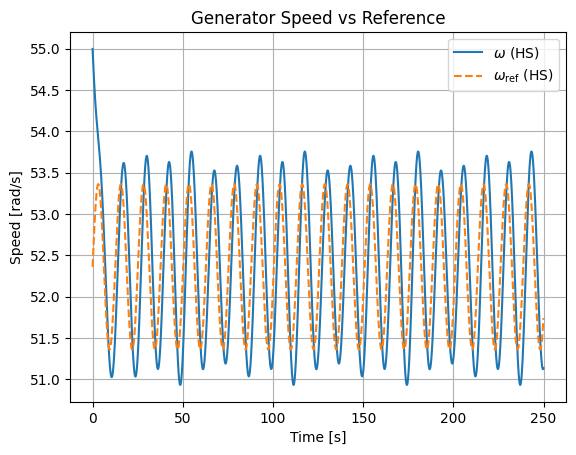

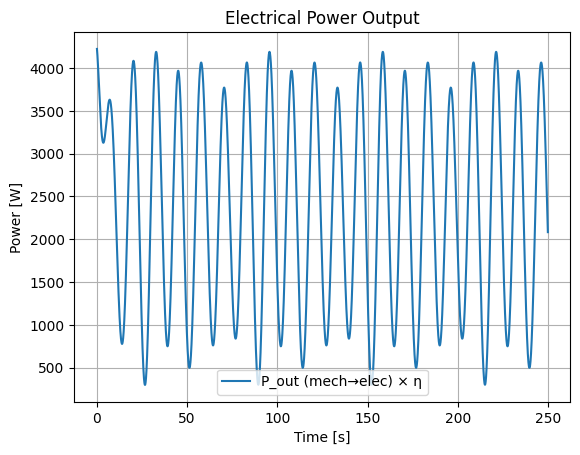

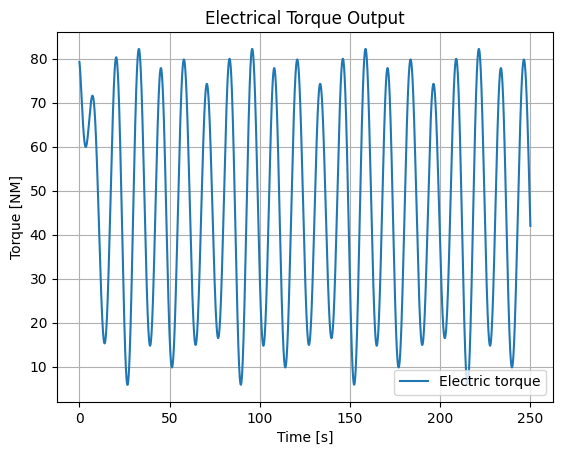

In [3]:
#Initiate PI controller
ctrl = PIController(kp,ki,T_max=3000)

#Simulation parameters
time = 250
dt = 0.01
timesteps = int(time/dt)
t_vec = np.arange(timesteps) * dt


w_rotor_hs = 55
v_rel = 3
T_electric_max = 3000


w_ref_rotor_hs_log = []
w_rotor_hs_log = []
P_mech_gen_log = []
T_electric_hs_log = []
T_mech_hs_log = []
v_rel_log = []
TSR_log = []


for t in range(timesteps):
    
    t_now = t * dt
    # Reference schedule (so you see different behaviors)
    # 0–5s: 50 rad/s; 5–12s: 70 rad/s; 12–16s: ramp down to 40; 16–20s: 40 + small sine dither
    w_ref_rotor_hs = 500 / 60 * 2 * math.pi + math.sin(0.5*t_now)

    # Slightly time-varying current speed (to see TSR effects)
    v_rel = 3.0 + 0.4 * math.sin(0.3 * t_now) 

    # e>0 -> want to break apply torque
    e = w_rotor_hs - w_ref_rotor_hs

    """Calculate electric and mechanical torque"""

    #Electric torque of generator
    T_electric_hs = ctrl.step(e,dt)

    #Mechanical Torque on ls side, T(w,v_rel)
    w_rotor_ls = w_rotor_hs / N #assuming ONE-mass ridig system

    TSR = w_rotor_ls * r_turbine / v_rel
    T_rotor_mechanical_ls = 1/2 * rho * A_turb * v_rel**2 * r_turbine * Cp(TSR) / (max(TSR,1e-6)) #No dividing by 0

    #Convert mechanical torque to hs side through gear
    T_rotor_mechanical_hs = T_rotor_mechanical_ls / N * eff_gear

    #inersia
    J_tot_hs = J_turbine / N**2 + J_generator

    #rotor w change
    w_rotor_hs_dot = (T_rotor_mechanical_hs - T_electric_hs)/(J_tot_hs)

    #update
    w_rotor_hs += w_rotor_hs_dot * dt

    #Power out
    P_mech_gen = T_electric_hs * w_rotor_hs * 0.97

    """Add to logs"""
    w_ref_rotor_hs_log.append(w_ref_rotor_hs)
    w_rotor_hs_log.append(w_rotor_hs)
    P_mech_gen_log.append(P_mech_gen)
    T_electric_hs_log.append(T_electric_hs)
    T_mech_hs_log.append(T_rotor_mechanical_hs)
    v_rel_log.append(v_rel)

    TSR_log.append(TSR)




import matplotlib.pyplot as plt
plt.figure()
plt.plot(t_vec, w_rotor_hs_log, label=r'$\omega$ (HS)')
plt.plot(t_vec, w_ref_rotor_hs_log, label=r'$\omega_{\rm ref}$ (HS)', linestyle='--')
plt.xlabel('Time [s]'); plt.ylabel('Speed [rad/s]'); plt.title('Generator Speed vs Reference'); plt.grid(True); plt.legend()

plt.figure()
plt.plot(t_vec, P_mech_gen_log, label='P_out (mech→elec) × η')
plt.xlabel('Time [s]'); plt.ylabel('Power [W]'); plt.title('Electrical Power Output'); plt.grid(True); plt.legend()


plt.figure()
plt.plot(t_vec, T_electric_hs_log, label='Electric torque')
plt.xlabel('Time [s]'); plt.ylabel('Torque [NM]'); plt.title('Electrical Torque Output'); plt.grid(True); plt.legend()


plt.show()

## Retrieve v_rel from data

Adjust Generator parameters J,Cp to get a v_rel that is reasonable 

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import root_scalar
from scipy.optimize import fsolve

In [4]:
r_turbine = 0.7 #???
A_turb = math.pi*r_turbine**2
rho = 1025
eff_gear = 0.99
N = 5

#Adjustable
J_generator = 1
J_turbine = 2

J_tot = J_turbine / N**2 + J_generator

def Cp(TSR):
    y = -0.4993241 + 0.3509036*TSR - 0.04359362*TSR**2 + 0.001469591*TSR**3 
    return max(y,0)


df = pd.read_csv('KiteData_20231202_f4_flood.csv', delimiter= ";")

for column in  df.columns:
    df[column] = df[column].str.replace(',', '.', regex=False).astype(float)



C:\Users\habu\AppData\Local\Temp\ipykernel_20932\1607393707.py:18: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('KiteData_20231202_f4_flood.csv', delimiter= ";")


T mechanical: [np.float64(227.62521766089708), 218.5198000765197, 221.99766614352868, 224.42531000913516, 214.92458400153305, 218.96851357144007, 232.9158293191774, 229.95175423845356, 230.25453028515219, 237.83732765357541, 236.23593604012967, 236.11245508452424, 244.12410545809362, 238.35515265833212, 242.5868501582085, 249.06357254318334, 244.40361813984555, 244.57206242385956, 250.40269852679614, 247.8439676935214, 251.650452980447, 259.72905024083445, 262.15959286109376, 262.2576604750834, 256.7396030686597, 257.3074698984111, 258.3733298619662, 262.98915492399647, 266.57221741056776, 270.4187087455382, 261.7833380188942, 265.357212395851, 268.47103499342177, 269.2631863145751, 274.57655683698886, 276.9352620051753, 266.82290549761876, 271.13146623155734, 267.7806204782307, 266.119056923036, 274.64764653170096, 275.15572778642104, 269.0741257604616, 283.39449958207825, 279.3215760592897, 275.19810248772416, 275.0429343573416, 278.47774328990926, 272.0268357811347, 267.463965107555

"\nplt.figure()\nplt.plot(t_vec, T_electric_hs_log, label='Electric torque')\nplt.xlabel('Time [s]'); plt.ylabel('Torque [NM]'); plt.title('Electrical Torque Output'); plt.grid(True); plt.legend()\n"

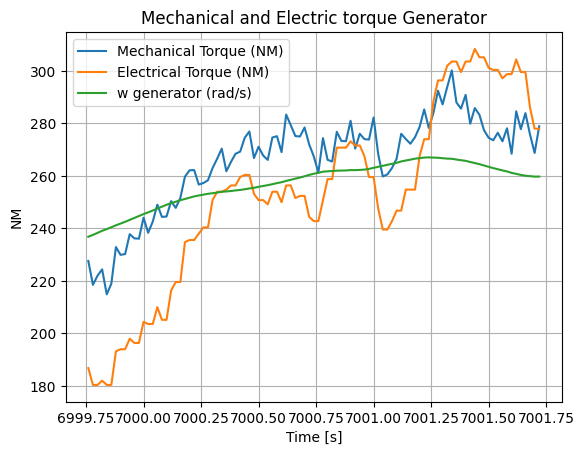

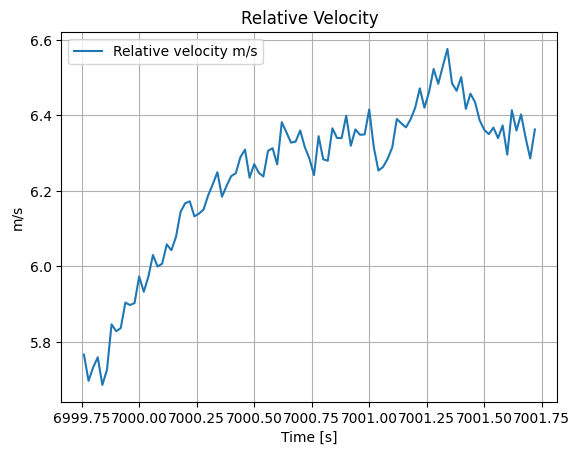

In [ ]:
def f(v,w,T):

    TSR = w*r_turbine/v

    y = 1/2 * rho*A_turb*(v**3)*Cp(TSR)/w - T

    return y

#Store logs
T_generator_mechanical_log = []
T_generator_electric_log = []

w_generator_log = []
v_rel_log = []
time_log = []

#Initalize at t = 7000 s
start_idx = 350000
stop_idx = 350100

prev_time = df.loc[start_idx, 'time']
w_generator_prev = df.loc[start_idx, 'GeneratorSpdRpm'] * 2*np.pi/60
v_guess = 2

for index, row in df.iloc[start_idx+1:stop_idx].iterrows():

    time = float(row['time'])
    w_generator_new_rpm = float(row['GeneratorSpdRpm'])
    w_generator_new = w_generator_new_rpm * 2*np.pi/60.0
    
    T_generator_el = float(row['Torque'])

    dt = float(time)-float(prev_time)

    w_dot_generator = (w_generator_new - w_generator_prev)/dt 

    T_generator_mechanical = J_tot*w_dot_generator+T_generator_el


    T_turbine = T_generator_mechanical * N
    w_turbine = w_generator_new / N 

    #Find relative velocity
    v_solution = fsolve(f,v_guess,args=(w_turbine,T_turbine),xtol=1e-3,maxfev=1000)[0]

    #Update logs
    w_generator_log.append(w_generator_new)
    v_rel_log.append(v_solution)
    T_generator_mechanical_log.append(T_generator_mechanical)
    T_generator_electric_log.append(T_generator_el)
    time_log.append(time)


    #Update params
    w_generator_prev = w_generator_new
    v_guess = v_solution
    prev_time = time

print(f"T mechanical: {T_generator_mechanical_log}")
print(f"w_generator: {w_generator_log}")
print(f"relative velocity: {v_rel_log}")


plt.figure()
plt.plot(time_log, T_generator_mechanical_log, label=r'Mechanical Torque (NM)')
plt.plot(time_log, T_generator_electric_log, label=r'Electrical Torque (NM)')
plt.plot(time_log, w_generator_log, label=r'w generator (rad/s)')
plt.xlabel('Time [s]'); plt.ylabel('NM'); plt.title('Mechanical and Electric torque Generator'); plt.grid(True); plt.legend()


plt.figure()
plt.plot(time_log, v_rel_log, label=r'Relative velocity m/s')
plt.xlabel('Time [s]'); plt.ylabel('m/s'); plt.title('Relative Velocity'); plt.grid(True); plt.legend()

"""
plt.figure()
plt.plot(t_vec, T_electric_hs_log, label='Electric torque')
plt.xlabel('Time [s]'); plt.ylabel('Torque [NM]'); plt.title('Electrical Torque Output'); plt.grid(True); plt.legend()
"""

### PI controller tuning from data

In [ ]:
class PIController:

    def __init__(self, kp, ki, T_max=3000):
        self.kp = kp
        self.ki = ki
        self.T_max = T_max
        self.I = 0.0 

    def step(self, error, dt):

        u = self.kp * error + self.ki * self.I

        # Braking ONLY but always generate some power min = 5 NM
        u = min(max(u, 5), self.T_max)

        if (u == 0 and error < 0) or (u == self.T_max and error > 0):
            pass
        else:
            self.I += error * dt

        return u 


In [74]:
def getPIcontrollerError(start_idx,stop_idx,ki,kp,J_tot):

    ctrl = PIController(kp,ki,T_max=3000)

    prev_time = df.loc[start_idx, 'time'] 
    w_generator_prev_data = df.loc[start_idx, 'GeneratorSpdRpm'] * 2*np.pi/60 

    #Reduce beginning jump
    T_electric_init = float(df.loc[start_idx, 'Torque'])
    e0 = w_generator_prev_data - float(df.loc[start_idx, 'TargetSpeed']) * 2*np.pi/60.0
    ctrl.I = (T_electric_init - ctrl.kp * e0) / max(ctrl.ki, 1e-9)

    w_rotor_tune = w_generator_prev_data #Let w tune start where data w starts
        
    #Store logs
    time_log = []
    w_generator_data_log = []
    w_generator_tune_log = []
    T_electric_tune_log  = []
    w_dot_rotor_tune_log = []
    w_dot_generator_data_log = []


    for index, row in df.iloc[start_idx+1:stop_idx].iterrows(): 
        
        time = float(row['time']) 
        dt = float(time)-float(prev_time) 

        """Get mechanical torque from data"""
        w_generator_new_data = float(row['GeneratorSpdRpm']) * 2*np.pi/60.0 
        w_dot_generator_data = (w_generator_new_data - w_generator_prev_data)/dt 

        T_generator_el_data = float(row['Torque']) 
        w_ref_data = float(row['TargetSpeed']) * 2*np.pi/60.0 

        T_generator_mechanical_data = J_tot*w_dot_generator_data + T_generator_el_data 

        """Set Electrical torque through Controller and calc w"""
        e = w_rotor_tune - w_ref_data

        T_electric_tune = ctrl.step(e,dt)

        w_dot_rotor_tune = (T_generator_mechanical_data - T_electric_tune)/(J_tot)

        #Update logs
        w_generator_data_log.append(w_generator_prev_data)
        w_generator_tune_log.append(w_rotor_tune)
        time_log.append(time)
        T_electric_tune_log.append(T_electric_tune)

        w_dot_rotor_tune_log.append(w_dot_rotor_tune)
        w_dot_generator_data_log.append(w_dot_generator_data)

        
        #Update params 
        w_rotor_tune += w_dot_rotor_tune * dt
        w_generator_prev_data = w_generator_new_data 
        prev_time = time 
    
    mean_squared_error = np.mean((np.array(w_generator_data_log)-np.array(w_generator_tune_log))**2)

    return mean_squared_error


    print(f"DATA: {w_generator_data_log}")
    print(f"TUNED: {w_generator_tune_log}")
    print(f"TUNED Torque: {T_electric_tune_log}")
    print(f"TUNED w_dot: {w_dot_rotor_tune_log}")
    print(f"DATA w_dot: {w_dot_generator_data_log}")


### Find best Ki,Kp combination

In [ ]:
#Initalize at t = 7000
start_idx = 300000
stop_idx = 400000

J_turbine = 1
J_generator = 1/2
J_tot = J_turbine / N**2 + J_generator


ki_list = [5*i for i in range(1,15)]
kp_list = [5*i for i in range(1,15)]

results = {}

for ki in ki_list:
    print(f"trying {ki}")
    for kp in kp_list:
        
        mean_squared_error = getPIcontrollerError(start_idx,stop_idx,ki,kp,J_tot)

        results[(ki,kp)] = mean_squared_error

best_key = (min(results,key = results.get))
best_val = results[best_key]

print(f"Best key {best_key} and best value {best_val}")

trying 5
trying 10
trying 15
trying 20
trying 25
trying 30
trying 35
trying 40
trying 45
trying 50
trying 55
trying 60
trying 65
trying 70
Best key (5, 35) and best value (5, 35)


### Get Generator efficiency curve

In [105]:
from scipy.interpolate import griddata,RegularGridInterpolator,PchipInterpolator
import numpy.ma as ma
from scipy import odr

[3189.99 2559.61 2511.99 2464.43 2416.9  2369.39 2321.9  2263.4  2204.96
 2146.56 2088.2  2029.91 1946.22 1862.6  1779.07 1695.61 1612.26 1528.99
 1445.63 1362.48 1279.37]
[319.82 399.43 386.84 373.77 360.19 346.04 331.35 317.47 302.85 287.46
 271.2  254.02 238.79 222.18 204.05 184.11 162.11 137.65 110.45  79.58
  44.33]
41.54058495293742


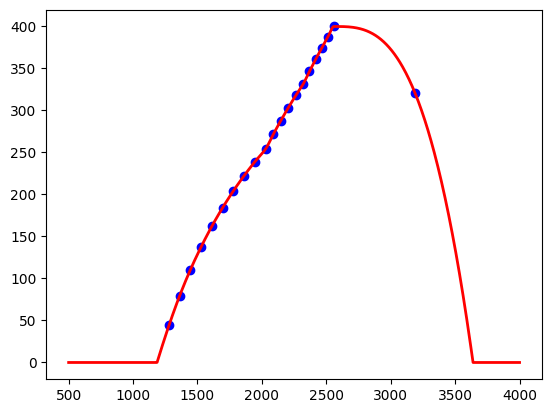

In [129]:

"""Fit polynomial to speed,torque"""

with open("GeneratorData.txt", "r") as f:
    lines = f.readlines()

Rotor_speed = np.array([float(val) for val in lines[0].strip().split(',')])
Rotor_torque = np.array([float(val) for val in lines[1].strip().split(',')])

print(Rotor_speed)
print(Rotor_torque)

sort_idx = np.argsort(Rotor_speed)
Rotor_speed = Rotor_speed[sort_idx]
Rotor_torque = Rotor_torque[sort_idx]


#Rotor_speed = np.append(Rotor_speed,[4000])
#Rotor_torque = np.append(Rotor_torque,[10])

#p = np.polyfit(Rotor_speed,Rotor_torque,5)
pchip = PchipInterpolator(Rotor_speed, Rotor_torque)

xmin,xmax = 500,4000

x_fit = np.linspace(xmin, xmax, 1000) 
#y_fit = np.polyval(p, x_fit)
#y_fit = np.maximum(y_fit)

y_fit = pchip(x_fit)
y_fit = np.maximum(pchip(x_fit), 0)

plt.figure()
plt.scatter(Rotor_speed, Rotor_torque, color='blue', label='Data points')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Fitted cubic polynomial')

print(pchip(3600))

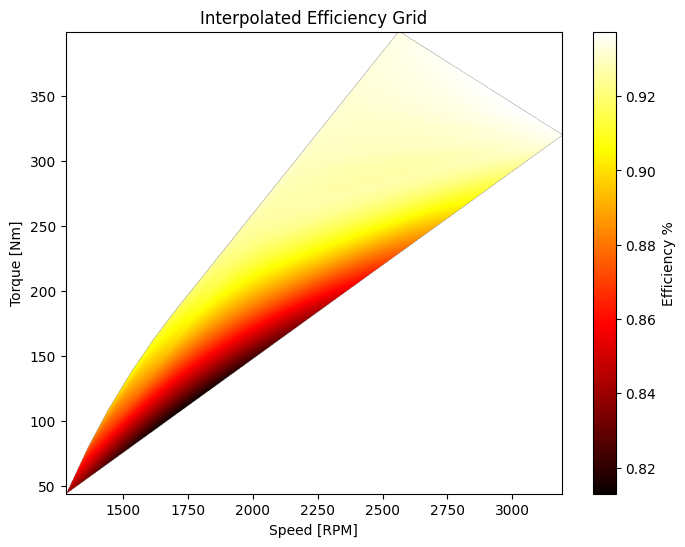

Efficiency = 0.7000


In [127]:
Rotor_speed = np.array([3189.99,2559.61,2511.99,2464.43,2416.90,2369.39,2321.90,2263.40,2204.96,2146.56,2088.20,2029.91,1946.22,1862.60,1779.07,1695.61,1612.26,1528.99,1445.63,1362.48,1279.37])
Rotor_torque = np.array([319.82,399.43,386.84,373.77,360.19,346.04,331.35,317.47,302.85,287.46,271.20,254.02,238.79,222.18,204.05,184.11,162.11,137.65,110.45,79.58,44.33])
efficiency = np.array([93.60,93.40,93.36,93.30,93.24,93.17,93.09,93.03,92.95,92.86,92.74,92.60,92.46,92.30,92.07,91.77,91.34,90.75,89.71,88.08,84.19])/100



#Rotor_speed = np.append(Rotor_speed,[3600])
#Rotor_torque = np.append(Rotor_torque,[41.54058495293742])
#efficiency = np.append(efficiency,[0.9])

#griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)
points = np.column_stack((Rotor_speed, Rotor_torque))


#Create grid
speedAxis = np.linspace(min(Rotor_speed), max(Rotor_speed), 1000)
torqueAxis = np.linspace(min(Rotor_torque), max(Rotor_torque), 1000)
speedGrid, torqueGrid = np.meshgrid(speedAxis,torqueAxis)


# Interpolate
efficiency_grid = griddata(points,efficiency,xi=(speedGrid, torqueGrid),method='cubic')

plt.figure(figsize=(8,6))
plt.imshow(
    efficiency_grid,
    origin='lower',
    cmap='hot',
    aspect='auto',
    extent=[
        np.min(Rotor_speed), np.max(Rotor_speed),
        np.min(Rotor_torque), np.max(Rotor_torque)
    ]
)
#plt.scatter(Rotor_speed,Rotor_torque)

plt.colorbar(label='Efficiency %')
plt.xlabel('Speed [RPM]')
plt.ylabel('Torque [Nm]')
plt.title('Interpolated Efficiency Grid')
plt.show()


"""Use this in the simulation as a start for a efficiency lookup table """

efficiency_grid_filled = np.where(np.isnan(efficiency_grid), 0.7, efficiency_grid)

interp_eff = RegularGridInterpolator(
    (torqueAxis, speedAxis),
    efficiency_grid_filled,
    bounds_error=False,
    fill_value=np.nan
)

torque = 50.0
rpm = 2000.87

eff = interp_eff((torque, rpm))  
print(f"Efficiency = {eff:.4f}")
